# Machine Learning for Everybody – Full Course

https://youtu.be/i_LwzRVP7bg

# FCC Bikes Regression

## Seoul Bike Sharing Demand Data Set

Data Source :http://data.seoul.go.kr/
SOUTH KOREA PUBLIC HOLIDAYS. URL: publicholidays.go.kr

https://archive.ics.uci.edu/ml/datasets/Seoul+Bike+Sharing+Demand

In [1]:
#!curl --create-dir -O --output-dir ./data https://archive.ics.uci.edu/ml/machine-learning-databases/00560/SeoulBikeData.csv

Additional Information

- Date : year-month-day
- Rented Bike count - Count of bikes rented at each hour
- Hour - Hour of he day
- Temperature-Temperature in Celsius
- Humidity - %
- Windspeed - m/s
- Visibility - 10m
- Dew point temperature - Celsius 
- Solar radiation - MJ/m2
- Rainfall - mm
- Snowfall - cm
- Seasons - Winter, Spring, Summer, Autumn
- Holiday - Holiday/No holiday
- Functional Day - NoFunc(Non Functional Hours), Fun(Functional hours)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from imblearn.over_sampling import RandomOverSampler

import copy
import seaborn as sns

import tensorflow as tf
# Disable all GPUS, TF Metal is very slow
# https://stackoverflow.com/questions/70653251/why-gpu-is-3-5-times-slower-than-the-cpu-on-apple-m1-mac
tf.config.set_visible_devices([], 'GPU')

In [3]:
dataset_cols = ["bike_count", "hour", "temp", "humidity", "wind", "visibility", "dew_pt_temp", "radiation", "rain", "snow", "functional"]

In [4]:
df = pd.read_csv("./data/SeoulBikeData.csv").drop(columns=["Date", "Holiday", "Seasons"], axis=1)
df.columns = dataset_cols
df["functional"] = (df["functional"] == "Yes").astype(int)
df = df[df["hour"] == 12]
df = df.drop(columns=["hour"], axis=1)

df.head()

,bike_count,temp,humidity,wind,visibility,dew_pt_temp,radiation,rain,snow,functional
12,449,1.7,23,1.4,2000,-17.2,1.11,0.0,0.0,1
36,479,4.3,41,1.3,1666,-7.8,1.09,0.0,0.0,1
60,333,5.8,85,1.7,349,3.4,0.43,0.0,0.0,1
84,393,-0.3,38,4.8,1823,-12.9,1.11,0.0,0.0,1
108,321,-2.3,25,0.0,1962,-19.7,0.00,0.0,0.0,1


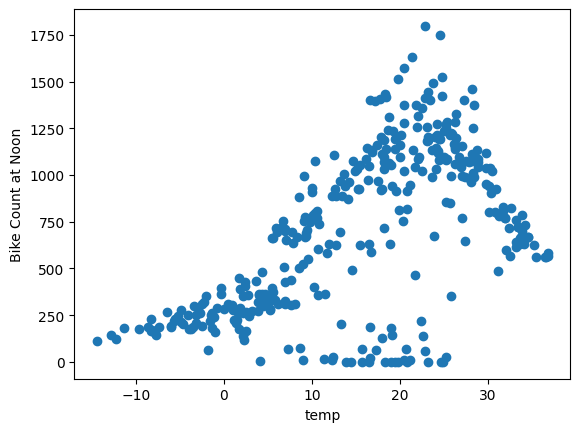

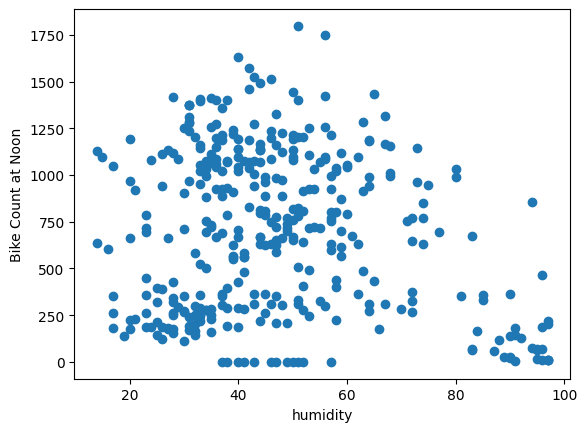

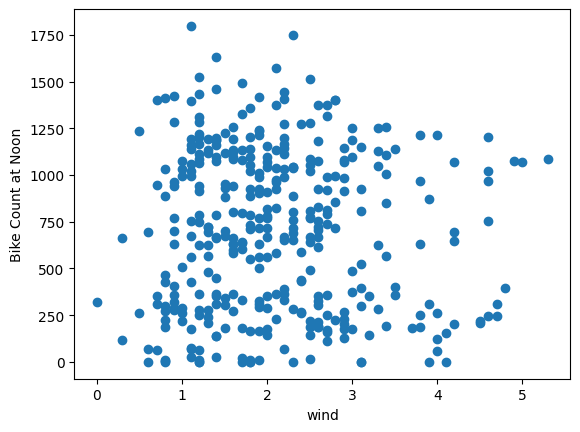

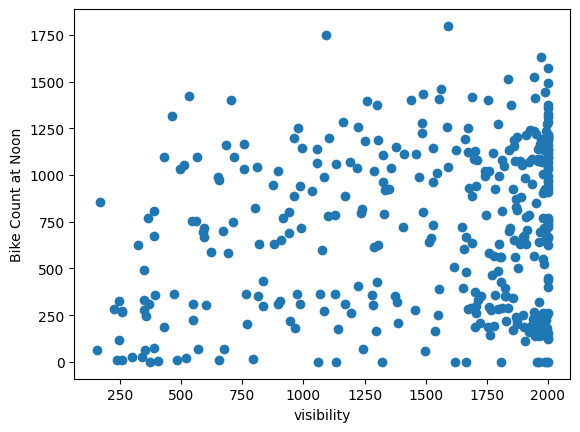

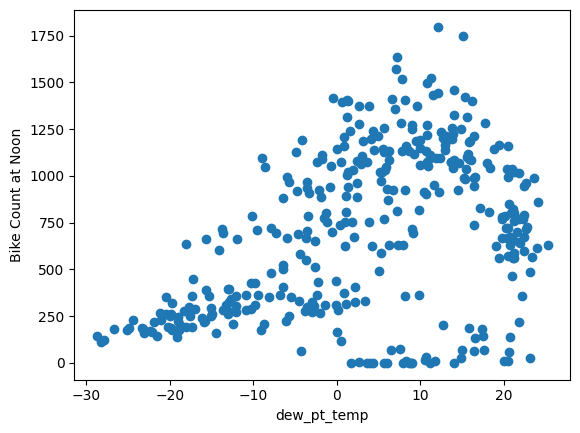

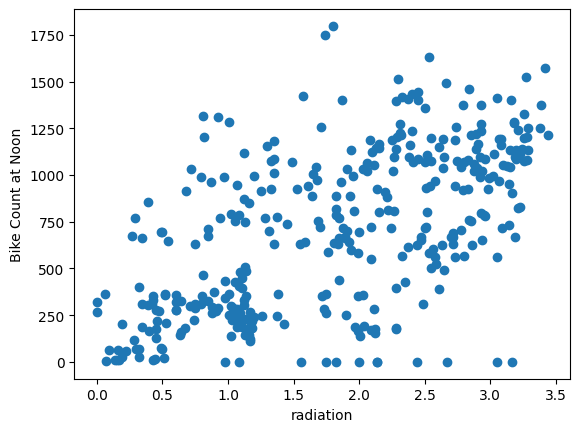

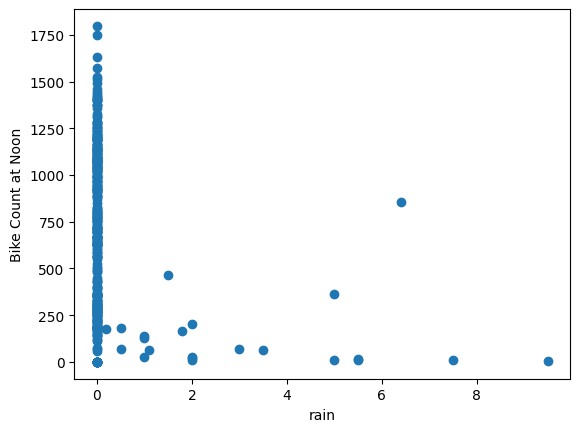

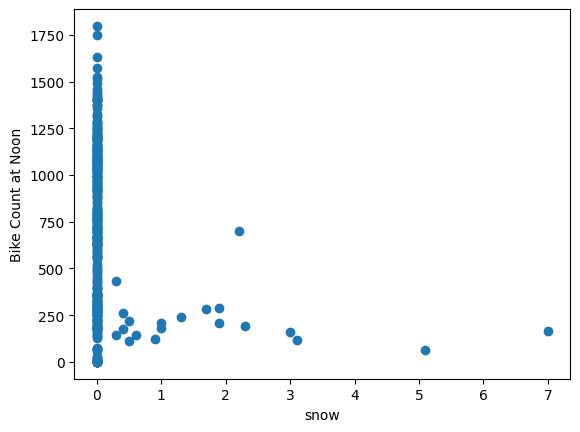

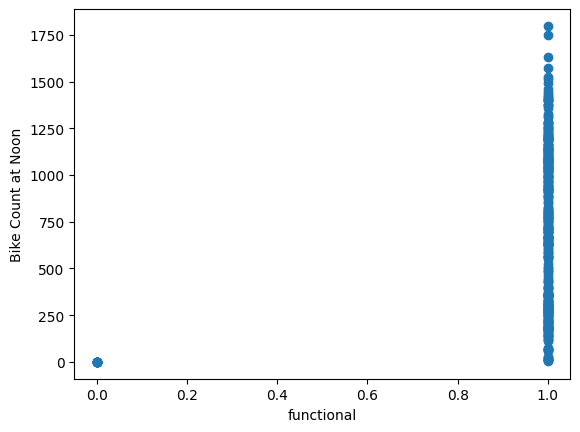

In [5]:
for label in df.columns[1:]:
    plt.scatter(df[label], df["bike_count"])
    plt.xlabel(label)
    plt.ylabel("Bike Count at Noon")
    plt.show()

In [6]:
df = df.drop(columns=["wind", "visibility", "functional"], axis=1)

In [7]:
df.head()

,bike_count,temp,humidity,dew_pt_temp,radiation,rain,snow
12,449,1.7,23,-17.2,1.11,0.0,0.0
36,479,4.3,41,-7.8,1.09,0.0,0.0
60,333,5.8,85,3.4,0.43,0.0,0.0
84,393,-0.3,38,-12.9,1.11,0.0,0.0
108,321,-2.3,25,-19.7,0.00,0.0,0.0


## Train/valid/test dataset

In [8]:
train, valid, test = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])

In [9]:
def get_xy(dataframe, y_label, x_labels=None):
    dataframe = copy.deepcopy(dataframe)
    if x_labels is None:
        X = dataframe[[c for c in dataframe.columns if c!=y_label]].values
    else:
        if len(x_labels) == 1:
            X = dataframe[x_labels[0]].values.reshape(-1, 1)
        else:
            X = dataframe[x_labels].values

    y = dataframe[y_label].values.reshape(-1, 1)
    data = np.hstack((X, y))

    return data, X, y

## Singular Linear Regression (Temperature)

In [10]:
_, X_train_temp, y_train_temp = get_xy(train, "bike_count", x_labels=["temp"])
_, X_val_temp, y_val_temp = get_xy(valid, "bike_count", x_labels=["temp"])
_, X_test_temp, y_test_temp = get_xy(test, "bike_count", x_labels=["temp"])

In [11]:
temp_reg = LinearRegression()
temp_reg.fit(X_train_temp, y_train_temp)

LinearRegression()

In [12]:
print(temp_reg.coef_, temp_reg.intercept_)

[[20.7668043]] [364.11550835]


In [13]:
temp_reg.score(X_test_temp, y_test_temp)

0.37649765184120065

Text(0.5, 0, 'Temperature')

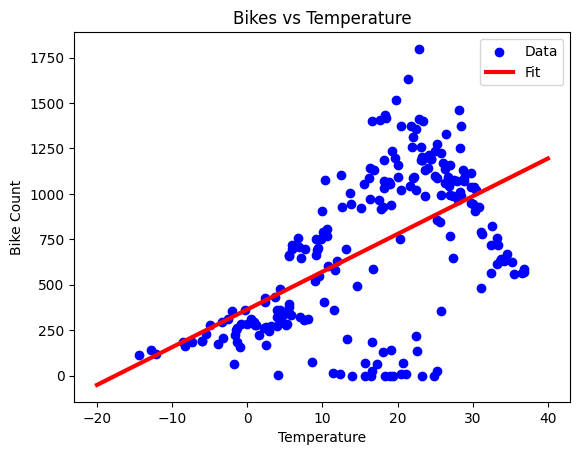

In [14]:
plt.scatter(X_train_temp, y_train_temp, label="Data", color="blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_reg.predict(np.array(x).reshape(-1, 1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bikes vs Temperature")
plt.ylabel("Bike Count")
plt.xlabel("Temperature")

## Multiple Linear Regression

In [15]:
_, X_train_all, y_train_all = get_xy(train, "bike_count", x_labels=df.columns[1:])
_, X_val_all, y_val_all = get_xy(valid, "bike_count", x_labels=df.columns[1:])
_, X_test_all, y_test_all = get_xy(test, "bike_count", x_labels=df.columns[1:])

In [16]:
all_reg = LinearRegression()
all_reg.fit(X_train_all, y_train_all)

LinearRegression()

In [17]:
all_reg.score(X_test_all, y_test_all)   

0.4455018939488612

## Regression with Neural Net

In [18]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('MSE')
  plt.legend()
  plt.grid(True)
  plt.show()

In [19]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalizer.adapt(X_train_temp.reshape(-1))

2023-06-10 11:10:26.213144: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [20]:
temp_nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(1)
])

In [21]:
temp_nn_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.1), loss="mean_squared_error")

In [22]:
history = temp_nn_model.fit(
    X_train_temp.reshape(-1), 
    y_train_temp, epochs=1000, 
    verbose=0, 
    validation_data=(X_val_temp, y_val_temp))

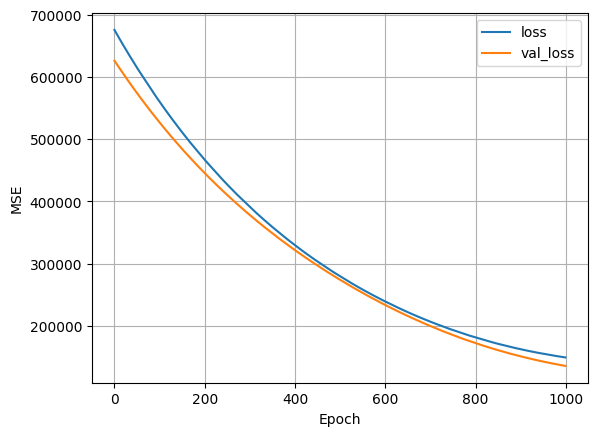

In [23]:
plot_loss(history)

4/4 [==============================] - 0s 778us/step


Text(0.5, 0, 'Temperature')

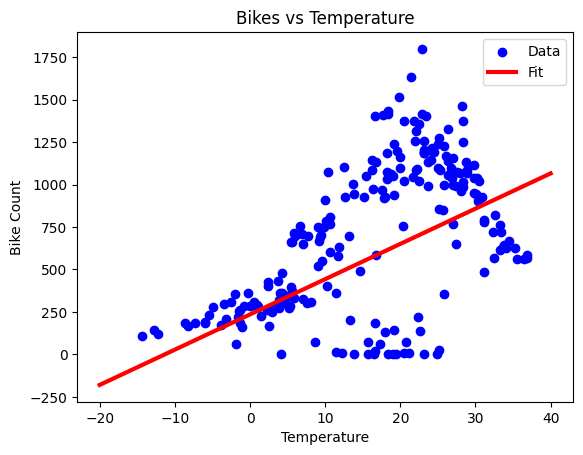

In [24]:
plt.scatter(X_train_temp, y_train_temp, label="Data", color="blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_nn_model.predict(np.array(x).reshape(-1, 1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bikes vs Temperature")
plt.ylabel("Bike Count")
plt.xlabel("Temperature")

## Neural Net


In [30]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalizer.adapt(X_train_temp.reshape(-1))

nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

nn_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), loss="mean_squared_error")

history = nn_model.fit(
    X_train_temp,
    y_train_temp, 
    epochs=100,
    verbose=0,
    validation_data=(X_val_temp, y_val_temp)
)

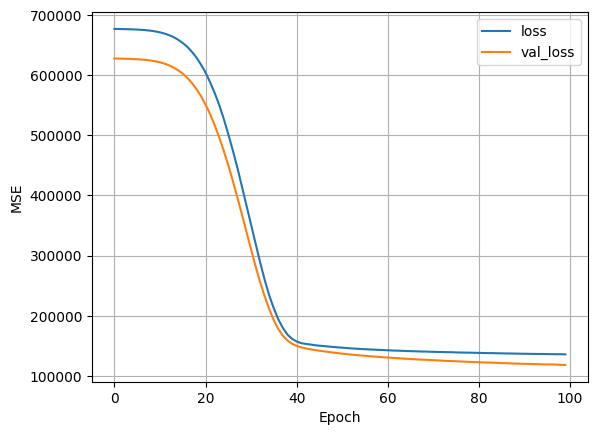

In [31]:
plot_loss(history)

4/4 [==============================] - 0s 820us/step


Text(0.5, 0, 'Temperature')

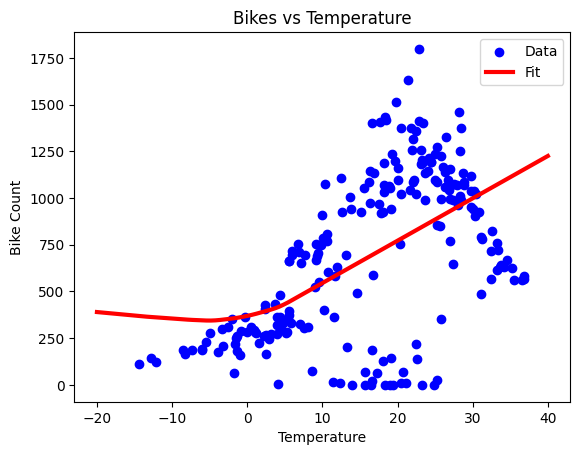

In [32]:
plt.scatter(X_train_temp, y_train_temp, label="Data", color="blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, nn_model.predict(np.array(x).reshape(-1, 1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bikes vs Temperature")
plt.ylabel("Bike Count")
plt.xlabel("Temperature")

In [44]:
all_normalizer = tf.keras.layers.Normalization(input_shape=(6,), axis=-1)
all_normalizer.adapt(X_train_all)

nn_model = tf.keras.Sequential([
    all_normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

nn_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), loss="mean_squared_error")

history = nn_model.fit(
    X_train_all,
    y_train_all, 
    epochs=100,
    verbose=0,
    validation_data=(X_val_all, y_val_all)
)

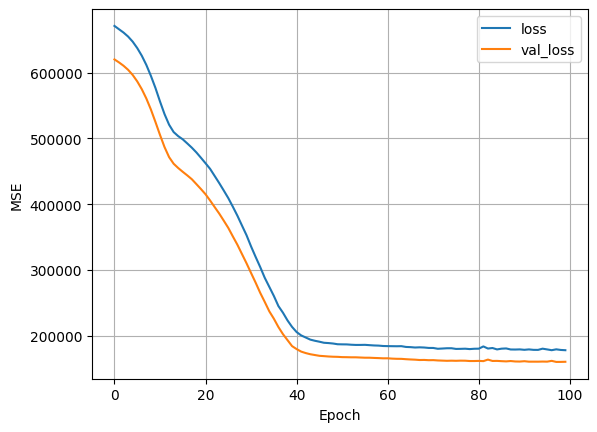

In [36]:
plot_loss(history)

In [45]:
y_pred_lr = all_reg.predict(X_test_all)
y_pred_nn = nn_model.predict(X_test_all)

3/3 [==============================] - 0s 916us/step


In [46]:
def MSE(y_pred, y_real):
    return (np.square(y_pred - y_real)).mean()

In [49]:
MSE(y_pred_nn, y_test_all)

96430.2494956813

In [48]:
MSE(y_pred_lr, y_test_all)

97991.34461286107

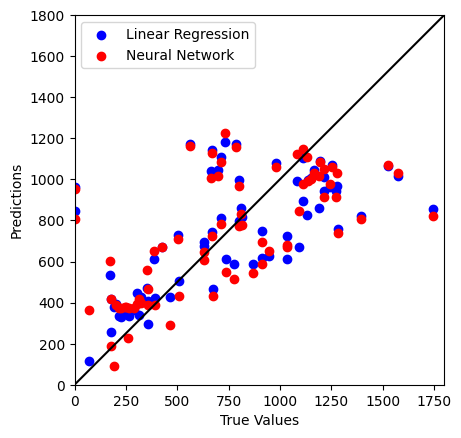

In [50]:
ax = plt.axes(aspect='equal')
plt.scatter(y_test_all, y_pred_lr, label="Linear Regression", color="blue")
plt.scatter(y_test_all, y_pred_nn, label="Neural Network", color="red")
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [0, 1800]
plt.xlim(lims)
plt.ylim(lims)
plt.legend()
_ = plt.plot(lims, lims, label="Perfect Fit", color="black")
